# Momentum

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Momentum import Momentum
from util.Save_result_return import save_to_csv




## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Momentum

In [6]:
account_size = 10000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/100,  commission=0.0002 )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   88.082491
Equity Final [$]                  9300.497269
Equity Peak [$]                  10311.160548
Return [%]                          -6.995027
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -0.361715
Volatility (Ann.) [%]                 1.85022
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -10.644407
Avg. Drawdown [%]                   -0.860515
Max. Drawdown Duration     5323 days 00:00:00
Avg. Drawdown Duration      309 days 00:00:00
# Trades                                  500
Win Rate [%]                              9.2
Best Trade [%]                      17.172742
Worst Trade [%]                     -9.906409
Avg. Trade [%]                    

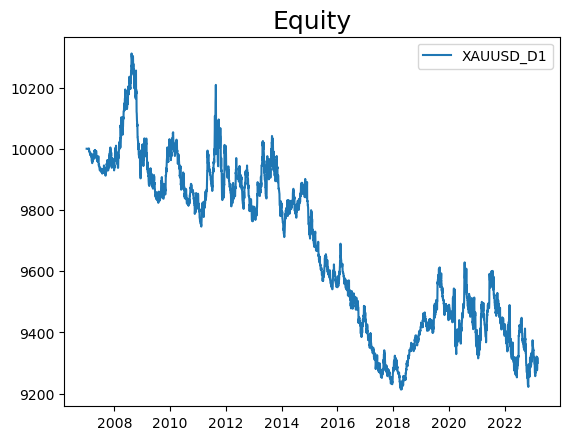

In [8]:
plot_equity_trades(result_D1['_equity_curve'], 'XAUUSD_D1' , account_size)

### Save output

In [9]:
save_to_csv(result_D1, '../../out/Technical_Strategy/Momentum/Backtest/result_D1.csv')  

## TF H4

In [10]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   90.822298
Equity Final [$]                  12048.77921
Equity Peak [$]                   12103.94921
Return [%]                          20.487792
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.935687
Volatility (Ann.) [%]                1.726564
Sharpe Ratio                         0.541936
Sortino Ratio                         0.86344
Calmar Ratio                         0.201992
Max. Drawdown [%]                     -4.6323
Avg. Drawdown [%]                   -0.241432
Max. Drawdown Duration     1294 days 20:00:00
Avg. Drawdown Duration       23 days 08:00:00
# Trades                                 2157
Win Rate [%]                         11.49745
Best Trade [%]                      14.125191
Worst Trade [%]                     -5.223876
Avg. Trade [%]                    

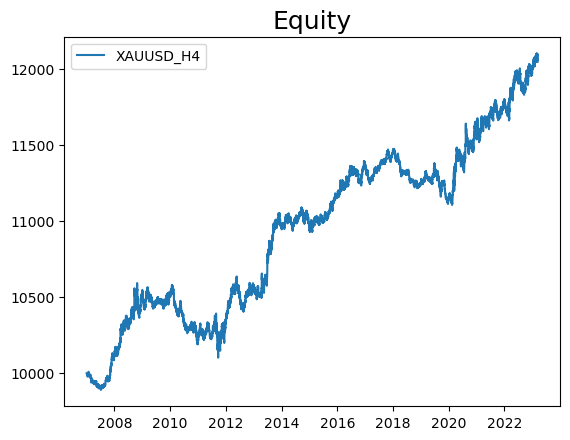

In [11]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4', account_size)

### Save output

In [12]:
save_to_csv(result_H4, '../../out/Technical_Strategy/Momentum/Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   90.634379
Equity Final [$]                   9037.56269
Equity Peak [$]                  10165.084471
Return [%]                          -9.624373
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                     -0.5044
Volatility (Ann.) [%]                1.932308
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -12.290562
Avg. Drawdown [%]                   -0.730508
Max. Drawdown Duration     5250 days 08:00:00
Avg. Drawdown Duration      197 days 01:00:00
# Trades                                 8583
Win Rate [%]                        10.054759
Best Trade [%]                        7.11643
Worst Trade [%]                     -3.943263
Avg. Trade [%]                    

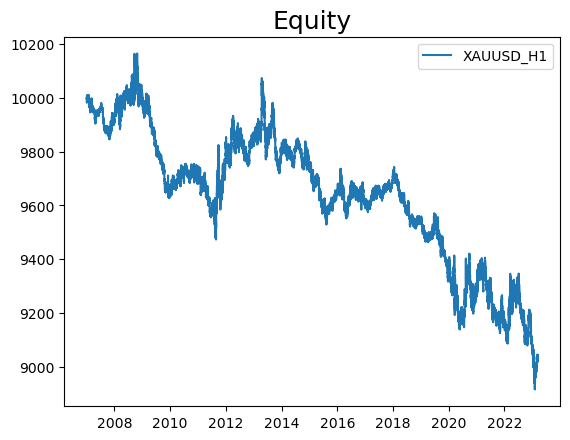

In [14]:
plot_equity_trades(result_H1['_equity_curve'], 'XAUUSD_H1', account_size)

### Save output

In [15]:
save_to_csv(result_H1, '../../out/Technical_Strategy/Momentum/Backtest/result_H1.csv')  

## TF M30 

In [16]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/100,  commission=0.0002 )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   90.764558
Equity Final [$]                  6630.490141
Equity Peak [$]                  10055.489192
Return [%]                         -33.695099
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                    -2.03091
Volatility (Ann.) [%]                2.227115
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -34.561859
Avg. Drawdown [%]                   -5.420194
Max. Drawdown Duration     5285 days 09:30:00
Avg. Drawdown Duration      844 days 14:05:00
# Trades                                16582
Win Rate [%]                         9.667109
Best Trade [%]                       6.024977
Worst Trade [%]                     -3.296813
Avg. Trade [%]                    

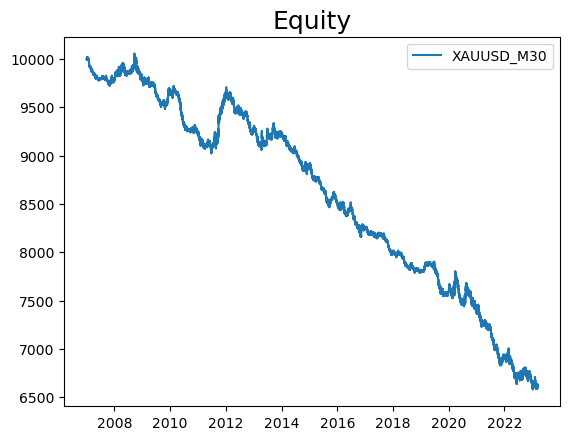

In [17]:
plot_equity_trades(result_M30['_equity_curve'], 'XAUUSD_M30', account_size)

### Save output

In [18]:
save_to_csv(result_M30, '../../out/Technical_Strategy/Momentum/Backtest/result_M30.csv')  